# Import Libraries

In [ ]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

## Data Transformations

We first start with defining our data transformations. We need to think what our data is and how can we augment it to correct represent images which it might not see otherwise.


In [ ]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.RandomAffine(0, translate=(0.07, 0.07)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values.
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])


# Dataset and Creating Train/Test Split

In [ ]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

100%|██████████| 9.91M/9.91M [00:00<00:00, 18.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 495kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.59MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 20.8MB/s]


# Dataloader Arguments & Test/Train Dataloaders


In [ ]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


# The model
Let's start with the model we first saw

In [ ]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 24

        # TRANSITION BLOCK 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=8, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24
        self.pool1 = nn.MaxPool2d(2, 2) # output_size = 12

        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 10
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 8
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 6

        # OUTPUT BLOCK
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10),
            # nn.ReLU(),
            # nn.Dropout(dropout_value)
        )


        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool1(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = self.gap(x)
        x = self.convblock9(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

# Model Params
Can't emphasize on how important viewing Model Summary is.
Unfortunately, there is no in-built model visualizer, so we have to take external help

In [ ]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5           [-1, 16, 24, 24]           1,152
              ReLU-6           [-1, 16, 24, 24]               0
       BatchNorm2d-7           [-1, 16, 24, 24]              32
           Dropout-8           [-1, 16, 24, 24]               0
            Conv2d-9            [-1, 8, 24, 24]             128
        MaxPool2d-10            [-1, 8, 12, 12]               0
           Conv2d-11            [-1, 8, 10, 10]             576
             ReLU-12            [-1, 8, 10, 10]               0
      BatchNorm2d-13            [-1, 8, 10, 10]              16
          Dropout-14            [-

# Training and Testing

Looking at logs can be boring, so we'll introduce **tqdm** progressbar to get cooler logs.

Let's write train and test functions

In [ ]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes.
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    loss = F.nll_loss(y_pred, target)
    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm

    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))

    test_acc.append(100. * correct / len(test_loader.dataset))

In [ ]:
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import OneCycleLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
# OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=15
)


EPOCHS = 20
for epoch in range(EPOCHS):
    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    scheduler.step()
    test(model, device, test_loader)

EPOCH: 0


Loss=0.3167599141597748 Batch_id=468 Accuracy=70.61: 100%|██████████| 469/469 [00:21<00:00, 21.97it/s]



Test set: Average loss: 0.2584, Accuracy: 9351/10000 (93.51%)

EPOCH: 1


Loss=0.4017540514469147 Batch_id=468 Accuracy=93.49: 100%|██████████| 469/469 [00:21<00:00, 21.95it/s]



Test set: Average loss: 0.0952, Accuracy: 9734/10000 (97.34%)

EPOCH: 2


Loss=0.09514430910348892 Batch_id=468 Accuracy=95.37: 100%|██████████| 469/469 [00:21<00:00, 22.03it/s]



Test set: Average loss: 0.0763, Accuracy: 9782/10000 (97.82%)

EPOCH: 3


Loss=0.19389384984970093 Batch_id=468 Accuracy=96.03: 100%|██████████| 469/469 [00:20<00:00, 23.20it/s]



Test set: Average loss: 0.0630, Accuracy: 9803/10000 (98.03%)

EPOCH: 4


Loss=0.14936822652816772 Batch_id=468 Accuracy=96.54: 100%|██████████| 469/469 [00:20<00:00, 22.69it/s]



Test set: Average loss: 0.0521, Accuracy: 9842/10000 (98.42%)

EPOCH: 5


Loss=0.11870890855789185 Batch_id=468 Accuracy=96.96: 100%|██████████| 469/469 [00:21<00:00, 22.01it/s]



Test set: Average loss: 0.0389, Accuracy: 9880/10000 (98.80%)

EPOCH: 6


Loss=0.133355975151062 Batch_id=468 Accuracy=97.03: 100%|██████████| 469/469 [00:21<00:00, 22.10it/s]



Test set: Average loss: 0.0409, Accuracy: 9865/10000 (98.65%)

EPOCH: 7


Loss=0.21623478829860687 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:20<00:00, 22.84it/s]



Test set: Average loss: 0.0413, Accuracy: 9857/10000 (98.57%)

EPOCH: 8


Loss=0.09057340770959854 Batch_id=468 Accuracy=97.54: 100%|██████████| 469/469 [00:20<00:00, 23.19it/s]



Test set: Average loss: 0.0371, Accuracy: 9877/10000 (98.77%)

EPOCH: 9


Loss=0.030926382169127464 Batch_id=468 Accuracy=97.51: 100%|██████████| 469/469 [00:21<00:00, 21.65it/s]



Test set: Average loss: 0.0360, Accuracy: 9882/10000 (98.82%)

EPOCH: 10


Loss=0.06182975322008133 Batch_id=288 Accuracy=97.70:  62%|██████▏   | 289/469 [00:13<00:08, 21.17it/s]


KeyboardInterrupt: 

# Let's Train and test our model

This time let's add a scheduler for out LR.

Text(0.5, 1.0, 'Test Accuracy')

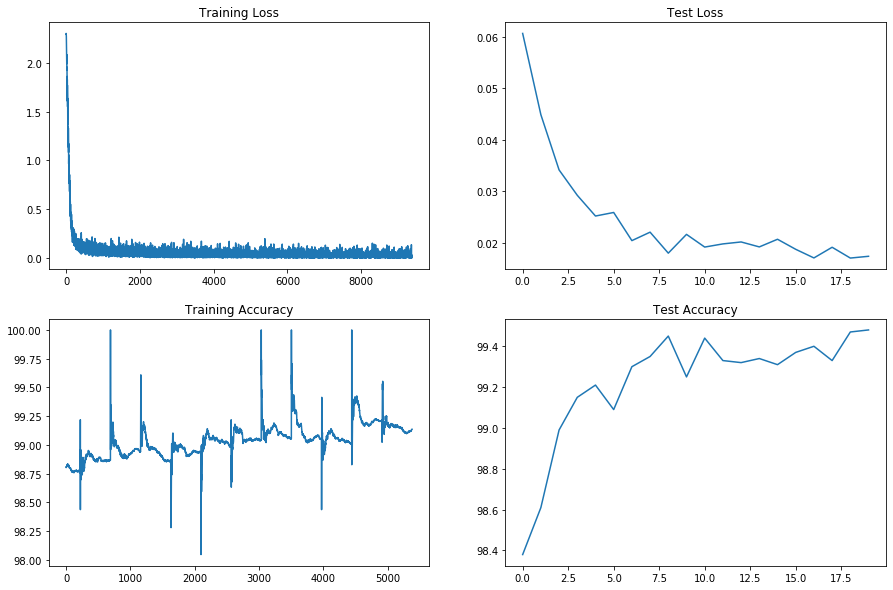

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [1]:
import albumentations as A
from albumentations.pytorch import ToTensorV2
import numpy as np

class AlbumentationsTransforms:
    def __init__(self, mean, std):
        self.aug = A.Compose([
            A.HorizontalFlip(p=0.5),
            A.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.1, rotate_limit=7, p=0.5),
            A.CoarseDropout(
                max_holes=1, max_height=16, max_width=16,
                min_holes=1, min_height=16, min_width=16,
                fill_value=mean,
                mask_fill_value=None,
                p=0.5
            ),
            A.Normalize(mean=mean, std=std),
            ToTensorV2()
        ])

    def __call__(self, image):
        image = np.array(image)
        return self.aug(image=image)["image"]

In [2]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2023, 0.1994, 0.2010)

In [3]:
from torchvision import datasets
from torch.utils.data import DataLoader

train_transforms = AlbumentationsTransforms(mean=mean, std=std)

test_transforms = A.Compose([
    A.Normalize(mean=mean, std=std),
    ToTensorV2()
])

class TestTransformWrapper:
    def __init__(self, aug):
        self.aug = aug

    def __call__(self, img):
        img = np.array(img)
        return self.aug(image=img)["image"]

# Load datasets
train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=TestTransformWrapper(test_transforms))

train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)

/usr/local/lib/python3.12/dist-packages/albumentations/core/validation.py:114: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)
/tmp/ipython-input-3076466830.py:10: UserWarning: Argument(s) 'max_holes, max_height, max_width, min_holes, min_height, min_width, fill_value, mask_fill_value' are not valid for transform CoarseDropout
  A.CoarseDropout(
100%|██████████| 170M/170M [00:03<00:00, 43.2MB/s]


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

# ------------------------------
# Data Augmentation
# ------------------------------
train_transforms = transforms.Compose([
    transforms.RandomRotation((-7.0, 7.0), fill=(1,)),   # small rotations
    transforms.RandomAffine(0, translate=(0.1, 0.1)),    # slight translations
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_dataset = datasets.CIFAR10('./data', train=True, download=True, transform=train_transforms)
test_dataset = datasets.CIFAR10('./data', train=False, download=True, transform=test_transforms)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)



100%|██████████| 170M/170M [00:03<00:00, 42.9MB/s]


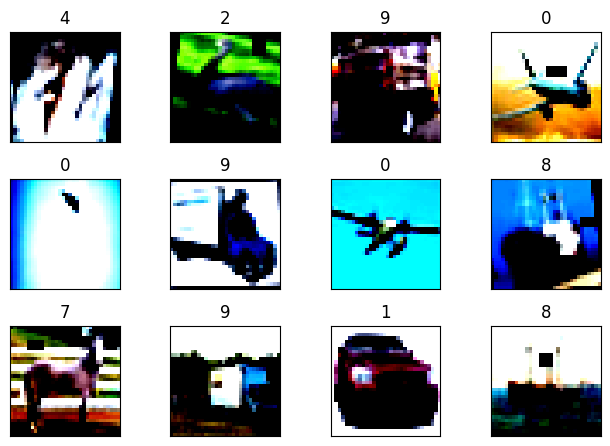

In [4]:
import matplotlib.pyplot as plt
import numpy as np

batch_data, batch_label = next(iter(train_loader))

fig = plt.figure()

for i in range(12):
  plt.subplot(3,4,i+1)
  plt.tight_layout()
  # CIFAR images are 3 channels, need to transpose for matplotlib
  plt.imshow(np.transpose(batch_data[i].numpy(), (1, 2, 0)))
  plt.title(batch_label[i].item())
  plt.xticks([])
  plt.yticks([])

In [28]:
import torch.nn as nn
import torch.nn.functional as F
# ------------------------------
# Model Definition
# ------------------------------
dropout_value = 0.05

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block 32 X 32
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 30

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 28

        # New Convolution Block (moved)
        self.convblock_new = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False, dilation=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 24


        # TRANSITION BLOCK 1 (using 1x1 conv for channel reduction)
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 24


        # CONVOLUTION BLOCK 2
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 22
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 20
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=0, bias=False, stride=2),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 10


        # TRANSITION BLOCK 2 (using 1x1 conv and average pooling for size reduction)
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=32, kernel_size=(1, 1), padding=0, bias=False),
        ) # output_size = 10
        self.avgpool2 = nn.AvgPool2d(2, 2) # output_size = 5

        # CONVOLUTION BLOCK 3
        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 5
        self.convblock9 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), padding=1, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        ) # output_size = 4


        # GLOBAL AVERAGE POOLING
        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=4) # output_size = 1
        )

        # OUTPUT BLOCK
        self.convblock11 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
        )


    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock_new(x) # New Convolution Block (moved)
        x = self.convblock3(x) # Transition with 1x1 conv
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x) # Transition with 1x1 conv
        x = self.avgpool2(x)    # Average pooling
        x = self.convblock8(x)
        x = self.convblock9(x)
        x = self.gap(x)
        x = self.convblock11(x)


        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [29]:
import torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 28, 28]          18,432
              ReLU-6           [-1, 64, 28, 28]               0
       BatchNorm2d-7           [-1, 64, 28, 28]             128
           Dropout-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 24, 24]          36,864
             ReLU-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
          Dropout-12           [-1, 64, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]           2,048
           Conv2d-14           [-1

In [34]:

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

# ------------------------------
# Training & Testing
# ------------------------------
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return acc

# ------------------------------
# Run Training
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=25
)

EPOCHS = 25
for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    acc = test(model, device, test_loader)


Epoch 1 Loss=1.5075 Acc=40.50: 100%|██████████| 391/391 [00:33<00:00, 11.67it/s]



Test set: Average loss: 1.2963, Accuracy: 5365/10000 (53.65%)



Epoch 2 Loss=1.1769 Acc=54.67: 100%|██████████| 391/391 [00:32<00:00, 11.87it/s]



Test set: Average loss: 1.0872, Accuracy: 6143/10000 (61.43%)



Epoch 3 Loss=0.8407 Acc=60.71: 100%|██████████| 391/391 [00:33<00:00, 11.67it/s]



Test set: Average loss: 1.1174, Accuracy: 6205/10000 (62.05%)



Epoch 4 Loss=0.8591 Acc=64.91: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 0.9112, Accuracy: 6807/10000 (68.07%)



Epoch 5 Loss=0.7056 Acc=68.08: 100%|██████████| 391/391 [00:33<00:00, 11.68it/s]



Test set: Average loss: 0.8480, Accuracy: 7103/10000 (71.03%)



Epoch 6 Loss=0.5915 Acc=70.65: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.7493, Accuracy: 7380/10000 (73.80%)



Epoch 7 Loss=0.8077 Acc=72.44: 100%|██████████| 391/391 [00:33<00:00, 11.80it/s]



Test set: Average loss: 0.7186, Accuracy: 7480/10000 (74.80%)



Epoch 8 Loss=0.6494 Acc=74.26: 100%|██████████| 391/391 [00:33<00:00, 11.51it/s]



Test set: Average loss: 0.7002, Accuracy: 7580/10000 (75.80%)



Epoch 9 Loss=0.7174 Acc=75.37: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]



Test set: Average loss: 0.6899, Accuracy: 7621/10000 (76.21%)



Epoch 10 Loss=0.7466 Acc=76.61: 100%|██████████| 391/391 [00:32<00:00, 11.91it/s]



Test set: Average loss: 0.6545, Accuracy: 7781/10000 (77.81%)



Epoch 11 Loss=0.6659 Acc=77.47: 100%|██████████| 391/391 [00:32<00:00, 11.95it/s]



Test set: Average loss: 0.6256, Accuracy: 7839/10000 (78.39%)



Epoch 12 Loss=0.7288 Acc=78.30: 100%|██████████| 391/391 [00:33<00:00, 11.82it/s]



Test set: Average loss: 0.6180, Accuracy: 7849/10000 (78.49%)



Epoch 13 Loss=0.6060 Acc=79.23: 100%|██████████| 391/391 [00:32<00:00, 11.86it/s]



Test set: Average loss: 0.5909, Accuracy: 7993/10000 (79.93%)



Epoch 14 Loss=0.5001 Acc=79.72: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]



Test set: Average loss: 0.5671, Accuracy: 8054/10000 (80.54%)



Epoch 15 Loss=0.4497 Acc=80.43: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]



Test set: Average loss: 0.5665, Accuracy: 8070/10000 (80.70%)



Epoch 16 Loss=0.5949 Acc=80.96: 100%|██████████| 391/391 [00:33<00:00, 11.67it/s]



Test set: Average loss: 0.5329, Accuracy: 8186/10000 (81.86%)



Epoch 17 Loss=0.6001 Acc=81.94: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]



Test set: Average loss: 0.5291, Accuracy: 8183/10000 (81.83%)



Epoch 18 Loss=0.4064 Acc=82.64: 100%|██████████| 391/391 [00:32<00:00, 12.11it/s]



Test set: Average loss: 0.5105, Accuracy: 8242/10000 (82.42%)



Epoch 19 Loss=0.5963 Acc=83.36: 100%|██████████| 391/391 [00:32<00:00, 11.93it/s]



Test set: Average loss: 0.5119, Accuracy: 8256/10000 (82.56%)



Epoch 20 Loss=0.4362 Acc=83.97: 100%|██████████| 391/391 [00:33<00:00, 11.83it/s]



Test set: Average loss: 0.4883, Accuracy: 8339/10000 (83.39%)



Epoch 21 Loss=0.5688 Acc=84.92: 100%|██████████| 391/391 [00:33<00:00, 11.81it/s]



Test set: Average loss: 0.4649, Accuracy: 8425/10000 (84.25%)



Epoch 22 Loss=0.4413 Acc=85.59: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]



Test set: Average loss: 0.4606, Accuracy: 8432/10000 (84.32%)



Epoch 23 Loss=0.4496 Acc=86.48: 100%|██████████| 391/391 [00:33<00:00, 11.85it/s]



Test set: Average loss: 0.4443, Accuracy: 8502/10000 (85.02%)



Epoch 24 Loss=0.3145 Acc=87.09: 100%|██████████| 391/391 [00:33<00:00, 11.78it/s]



Test set: Average loss: 0.4415, Accuracy: 8490/10000 (84.90%)



Epoch 25 Loss=0.5632 Acc=87.45: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.4401, Accuracy: 8500/10000 (85.00%)



In [1]:
import torch.nn as nn
import torch.nn.functional as F
# ------------------------------
# Model Definition
# ------------------------------
dropout_value = 0.05

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input: 32x32x3, RF=1

        # BLOCK 1
        self.convblock1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=0, bias=False), # 30x30x32, RF=3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        )

        # BLOCK 2
        self.convblock2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=0, bias=False), # 28x28x64, RF=5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # BLOCK 3 (Dilation=2)
        self.convblock_new = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=0, dilation=2, bias=False), # 24x24x64, RF=9
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # TRANSITION 1
        self.convblock3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False), # 24x24x32, RF=9
        )

        # BLOCK 4 (Depthwise + Pointwise)
        self.convblock4 = nn.Sequential(
            # Depthwise Convolution
            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32, bias=False), # 24x24x32, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(32),
            # Pointwise Convolution
            nn.Conv2d(32, 64, kernel_size=1, padding=0, bias=False), # 24x24x64, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # BLOCK 5
        self.convblock5 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=False), # 22x22x64, RF=13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # BLOCK 6 (Stride=2)
        self.convblock6 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=0, stride=2, bias=False), # 10x10x64, RF=17
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # TRANSITION 2
        self.convblock7 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False), # 10x10x32, RF=17
        )
        self.avgpool2 = nn.AvgPool2d(2, 2) # 5x5x32, RF=21

        # BLOCK 7
        self.convblock8 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False), # 5x5x64, RF=25
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # BLOCK 8
        self.convblock9 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False), # 5x5x64, RF=29
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # GAP
        self.gap = nn.AvgPool2d(kernel_size=5) # 1x1x64, RF= (covers full)

        # OUTPUT
        self.convblock11 = nn.Conv2d(64, 10, kernel_size=1, padding=0, bias=False) # 1x1x10

    def forward(self, x):
        x = self.convblock1(x)  # 30x30x32
        x = self.convblock2(x)  # 28x28x64
        x = self.convblock_new(x) # 24x24x64
        x = self.convblock3(x)  # 24x24x32
        x = self.convblock4(x)  # 24x24x64
        x = self.convblock5(x)  # 22x22x64
        x = self.convblock6(x)  # 10x10x64
        x = self.convblock7(x)  # 10x10x32
        x = self.avgpool2(x)    # 5x5x32
        x = self.convblock8(x)  # 5x5x64
        x = self.convblock9(x)  # 5x5x64
        x = self.gap(x)         # 1x1x64
        x = self.convblock11(x) # 1x1x10
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

import torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 28, 28]          18,432
              ReLU-6           [-1, 64, 28, 28]               0
       BatchNorm2d-7           [-1, 64, 28, 28]             128
           Dropout-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 24, 24]          36,864
             ReLU-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
          Dropout-12           [-1, 64, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]           2,048
           Conv2d-14           [-1

In [7]:

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

# ------------------------------
# Training & Testing
# ------------------------------
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return acc

# ------------------------------
# Run Training
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=30
)

EPOCHS = 30
for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    acc = test(model, device, test_loader)


Epoch 1 Loss=1.4220 Acc=41.15: 100%|██████████| 391/391 [00:35<00:00, 11.04it/s]



Test set: Average loss: 1.2715, Accuracy: 5331/10000 (53.31%)



Epoch 2 Loss=1.0143 Acc=57.39: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]



Test set: Average loss: 1.0213, Accuracy: 6332/10000 (63.32%)



Epoch 3 Loss=0.9173 Acc=63.33: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.9125, Accuracy: 6809/10000 (68.09%)



Epoch 4 Loss=0.8813 Acc=67.53: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.8370, Accuracy: 7018/10000 (70.18%)



Epoch 5 Loss=0.7782 Acc=70.44: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 0.7630, Accuracy: 7307/10000 (73.07%)



Epoch 6 Loss=0.7961 Acc=72.53: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.7005, Accuracy: 7562/10000 (75.62%)



Epoch 7 Loss=0.7221 Acc=74.38: 100%|██████████| 391/391 [00:33<00:00, 11.84it/s]



Test set: Average loss: 0.6787, Accuracy: 7633/10000 (76.33%)



Epoch 8 Loss=0.7983 Acc=75.92: 100%|██████████| 391/391 [00:32<00:00, 12.07it/s]



Test set: Average loss: 0.6331, Accuracy: 7785/10000 (77.85%)



Epoch 9 Loss=0.5234 Acc=77.05: 100%|██████████| 391/391 [00:32<00:00, 11.96it/s]



Test set: Average loss: 0.6103, Accuracy: 7902/10000 (79.02%)



Epoch 10 Loss=0.7570 Acc=78.08: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]



Test set: Average loss: 0.6013, Accuracy: 7888/10000 (78.88%)



Epoch 11 Loss=0.7804 Acc=78.77: 100%|██████████| 391/391 [00:33<00:00, 11.53it/s]



Test set: Average loss: 0.5693, Accuracy: 7972/10000 (79.72%)



Epoch 12 Loss=0.4297 Acc=79.70: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.5517, Accuracy: 8073/10000 (80.73%)



Epoch 13 Loss=0.5064 Acc=80.49: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.5549, Accuracy: 8062/10000 (80.62%)



Epoch 14 Loss=0.4753 Acc=81.09: 100%|██████████| 391/391 [00:33<00:00, 11.80it/s]



Test set: Average loss: 0.5348, Accuracy: 8140/10000 (81.40%)



Epoch 15 Loss=0.6564 Acc=81.89: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]



Test set: Average loss: 0.5368, Accuracy: 8112/10000 (81.12%)



Epoch 16 Loss=0.4568 Acc=82.26: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.5065, Accuracy: 8240/10000 (82.40%)



Epoch 17 Loss=0.4696 Acc=82.75: 100%|██████████| 391/391 [00:33<00:00, 11.73it/s]



Test set: Average loss: 0.5135, Accuracy: 8241/10000 (82.41%)



Epoch 18 Loss=0.4571 Acc=83.46: 100%|██████████| 391/391 [00:33<00:00, 11.70it/s]



Test set: Average loss: 0.5092, Accuracy: 8243/10000 (82.43%)



Epoch 19 Loss=0.5373 Acc=83.80: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]



Test set: Average loss: 0.4832, Accuracy: 8307/10000 (83.07%)



Epoch 20 Loss=0.5746 Acc=84.43: 100%|██████████| 391/391 [00:33<00:00, 11.82it/s]



Test set: Average loss: 0.4676, Accuracy: 8398/10000 (83.98%)



Epoch 21 Loss=0.4396 Acc=84.99: 100%|██████████| 391/391 [00:32<00:00, 11.92it/s]



Test set: Average loss: 0.4657, Accuracy: 8397/10000 (83.97%)



Epoch 22 Loss=0.3789 Acc=85.20: 100%|██████████| 391/391 [00:32<00:00, 11.88it/s]



Test set: Average loss: 0.4603, Accuracy: 8427/10000 (84.27%)



Epoch 23 Loss=0.4840 Acc=85.94: 100%|██████████| 391/391 [00:33<00:00, 11.79it/s]



Test set: Average loss: 0.4331, Accuracy: 8511/10000 (85.11%)



Epoch 24 Loss=0.3760 Acc=86.71: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 0.4372, Accuracy: 8491/10000 (84.91%)



Epoch 25 Loss=0.3361 Acc=87.18:  57%|█████▋    | 223/391 [00:19<00:14, 11.51it/s]


KeyboardInterrupt: 

NameError: name 'train_losses' is not defined

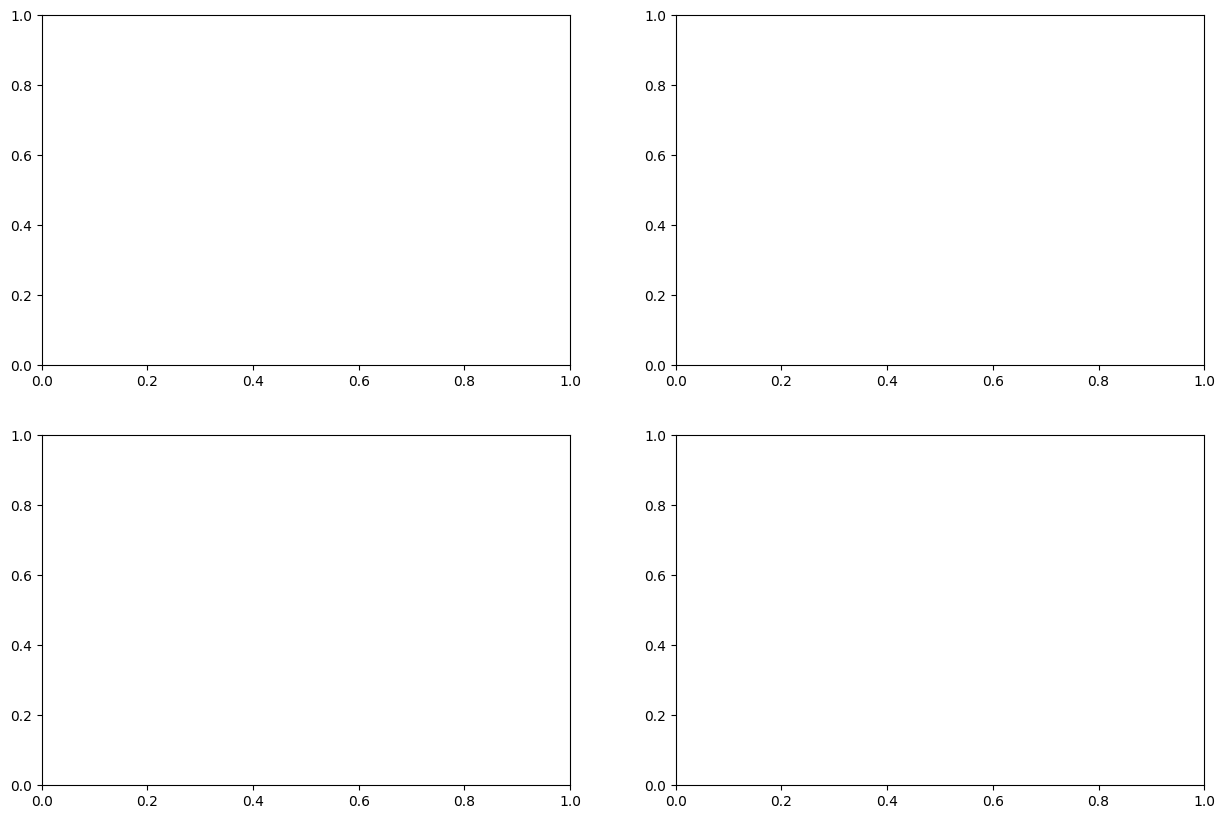

In [8]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

In [5]:
import torch.nn as nn
import torch.nn.functional as F
# ------------------------------
# Model Definition
# ------------------------------
dropout_value = 0.05
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1 (C1) — RF: 3 → 9
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=0, bias=False),   # 32x32x3 → 30x30x32, RF=3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),

            nn.Conv2d(32, 64, kernel_size=3, padding=0, bias=False),  # 30x30x32 → 28x28x64, RF=5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, dilation=2, bias=False),  # 28x28x64 → 24x24x64, RF=9
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False),  # 24x24x64 → 24x24x32
        )

        # CONVOLUTION BLOCK 2 (C2) — RF: 11 → 17
        self.c2 = nn.Sequential(
            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32, bias=False),  # Depthwise → 24x24x32, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=1, padding=0, bias=False),  # Pointwise → 24x24x64, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=False),  # 24x24x64 → 22x22x64, RF=13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, stride=2, bias=False),  # 22x22x64 → 10x10x64, RF=17
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
        )

        # CONVOLUTION BLOCK 3 (C3) — RF: 21 → 29
        self.c3 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False),  # 10x10x64 → 10x10x32, RF=17
            nn.AvgPool2d(2, 2),                                       # 10x10x32 → 5x5x32, RF=21

            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),  # 5x5x32 → 5x5x64, RF=25
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),  # 5x5x64 → 5x5x64, RF=29
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),
        )

        # CONVOLUTION BLOCK 4 (C4) — RF: 44
        self.c4 = nn.Sequential(
            nn.AvgPool2d(kernel_size=5)  # 5x5x64 → 1x1x64, RF=44 (covers full input)
        )

        # OUTPUT BLOCK
        self.output = nn.Sequential(
            nn.Conv2d(64, 10, kernel_size=1, padding=0, bias=False)  # 1x1x64 → 1x1x10
        )

    def forward(self, x):
        x = self.c1(x)       # → 24x24x32
        x = self.c2(x)       # → 10x10x64
        x = self.c3(x)       # → 5x5 → 1x1x64
        x = self.c4(x)       # → 1x1x64
        x = self.output(x)   # → 1x1x10
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

import torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 28, 28]          18,432
              ReLU-6           [-1, 64, 28, 28]               0
       BatchNorm2d-7           [-1, 64, 28, 28]             128
           Dropout-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 24, 24]          36,864
             ReLU-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
          Dropout-12           [-1, 64, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]           2,048
           Conv2d-14           [-1

In [6]:

import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

# ------------------------------
# Training & Testing
# ------------------------------
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return acc

# ------------------------------
# Run Training
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=30
)

EPOCHS = 30
for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    acc = test(model, device, test_loader)


Epoch 1 Loss=1.2894 Acc=41.61: 100%|██████████| 391/391 [00:35<00:00, 10.88it/s]



Test set: Average loss: 1.2453, Accuracy: 5507/10000 (55.07%)



Epoch 2 Loss=1.1974 Acc=57.29: 100%|██████████| 391/391 [00:34<00:00, 11.50it/s]



Test set: Average loss: 1.0588, Accuracy: 6184/10000 (61.84%)



Epoch 3 Loss=1.2359 Acc=63.20: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.9969, Accuracy: 6522/10000 (65.22%)



Epoch 4 Loss=1.1301 Acc=67.32: 100%|██████████| 391/391 [00:33<00:00, 11.56it/s]



Test set: Average loss: 0.8256, Accuracy: 7113/10000 (71.13%)



Epoch 5 Loss=0.9605 Acc=70.21: 100%|██████████| 391/391 [00:37<00:00, 10.30it/s]



Test set: Average loss: 0.7894, Accuracy: 7240/10000 (72.40%)



Epoch 6 Loss=0.6668 Acc=72.46: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 0.7311, Accuracy: 7437/10000 (74.37%)



Epoch 7 Loss=0.7755 Acc=73.89: 100%|██████████| 391/391 [00:36<00:00, 10.80it/s]



Test set: Average loss: 0.6951, Accuracy: 7624/10000 (76.24%)



Epoch 8 Loss=0.5864 Acc=75.85: 100%|██████████| 391/391 [00:34<00:00, 11.49it/s]



Test set: Average loss: 0.6362, Accuracy: 7767/10000 (77.67%)



Epoch 9 Loss=0.5895 Acc=76.79: 100%|██████████| 391/391 [00:34<00:00, 11.42it/s]



Test set: Average loss: 0.6237, Accuracy: 7857/10000 (78.57%)



Epoch 10 Loss=0.4804 Acc=78.26: 100%|██████████| 391/391 [00:34<00:00, 11.41it/s]



Test set: Average loss: 0.5944, Accuracy: 7927/10000 (79.27%)



Epoch 11 Loss=0.7880 Acc=78.86: 100%|██████████| 391/391 [00:34<00:00, 11.40it/s]



Test set: Average loss: 0.5817, Accuracy: 7990/10000 (79.90%)



Epoch 12 Loss=0.5641 Acc=79.84: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.5676, Accuracy: 8056/10000 (80.56%)



Epoch 13 Loss=0.5475 Acc=80.45: 100%|██████████| 391/391 [00:35<00:00, 11.10it/s]



Test set: Average loss: 0.5388, Accuracy: 8188/10000 (81.88%)



Epoch 14 Loss=0.4938 Acc=81.16: 100%|██████████| 391/391 [00:34<00:00, 11.44it/s]



Test set: Average loss: 0.5317, Accuracy: 8172/10000 (81.72%)



Epoch 15 Loss=0.3596 Acc=81.51: 100%|██████████| 391/391 [00:37<00:00, 10.31it/s]



Test set: Average loss: 0.5274, Accuracy: 8165/10000 (81.65%)



Epoch 16 Loss=0.3903 Acc=82.47: 100%|██████████| 391/391 [00:36<00:00, 10.60it/s]



Test set: Average loss: 0.4904, Accuracy: 8313/10000 (83.13%)



Epoch 17 Loss=0.4814 Acc=82.73: 100%|██████████| 391/391 [00:33<00:00, 11.59it/s]



Test set: Average loss: 0.4875, Accuracy: 8296/10000 (82.96%)



Epoch 18 Loss=0.5352 Acc=83.27: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 0.5051, Accuracy: 8303/10000 (83.03%)



Epoch 19 Loss=0.4681 Acc=83.84: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 0.4723, Accuracy: 8394/10000 (83.94%)



Epoch 20 Loss=0.3308 Acc=84.31: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.4732, Accuracy: 8398/10000 (83.98%)



Epoch 21 Loss=0.6557 Acc=84.89: 100%|██████████| 391/391 [00:33<00:00, 11.62it/s]



Test set: Average loss: 0.4662, Accuracy: 8414/10000 (84.14%)



Epoch 22 Loss=0.3532 Acc=85.34: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.4514, Accuracy: 8487/10000 (84.87%)



Epoch 23 Loss=0.3095 Acc=85.71: 100%|██████████| 391/391 [00:33<00:00, 11.52it/s]



Test set: Average loss: 0.4381, Accuracy: 8479/10000 (84.79%)



Epoch 24 Loss=0.3466 Acc=86.58: 100%|██████████| 391/391 [00:33<00:00, 11.71it/s]



Test set: Average loss: 0.4238, Accuracy: 8558/10000 (85.58%)



Epoch 25 Loss=0.3084 Acc=87.29: 100%|██████████| 391/391 [00:33<00:00, 11.60it/s]



Test set: Average loss: 0.4067, Accuracy: 8608/10000 (86.08%)



Epoch 26 Loss=0.4132 Acc=87.89: 100%|██████████| 391/391 [00:33<00:00, 11.63it/s]



Test set: Average loss: 0.4061, Accuracy: 8634/10000 (86.34%)



Epoch 27 Loss=0.3834 Acc=88.27: 100%|██████████| 391/391 [00:33<00:00, 11.61it/s]



Test set: Average loss: 0.4006, Accuracy: 8654/10000 (86.54%)



Epoch 28 Loss=0.3412 Acc=88.87: 100%|██████████| 391/391 [00:33<00:00, 11.69it/s]



Test set: Average loss: 0.3910, Accuracy: 8663/10000 (86.63%)



Epoch 29 Loss=0.2414 Acc=89.15: 100%|██████████| 391/391 [00:33<00:00, 11.74it/s]



Test set: Average loss: 0.3860, Accuracy: 8695/10000 (86.95%)



Epoch 30 Loss=0.3222 Acc=89.55: 100%|██████████| 391/391 [00:33<00:00, 11.57it/s]



Test set: Average loss: 0.3850, Accuracy: 8701/10000 (87.01%)



In [5]:
import torch.nn as nn
import torch.nn.functional as F
# ------------------------------
# Model Definition
# ------------------------------
dropout_value = 0.05

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        # CONVOLUTION BLOCK 1 (C1) — RF: 9
        self.c1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, padding=0, bias=False),  # 32x32 → 30x30, RF=3
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value),

            nn.Conv2d(32, 64, kernel_size=3, padding=0, bias=False), # 30x30 → 28x28, RF=5
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, dilation=2, bias=False), # 28x28 → 24x24, RF=9
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 2 (C2) — RF: 13
        self.c2 = nn.Sequential(
            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False), # 24x24 → 24x24, RF=9
            nn.Conv2d(32, 32, kernel_size=3, padding=1, groups=32, bias=False),  # Depthwise, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 64, kernel_size=1, padding=0, bias=False),  # Pointwise, RF=11
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=0, bias=False), # 24x24 → 22x22, RF=13
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value)
        )

        # CONVOLUTION BLOCK 3 (C3) — RF: 21
        self.c3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=0, stride=2, bias=False), # 22x22 → 10x10, RF=17
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 32, kernel_size=1, padding=0, bias=False), # 10x10 → 10x10, RF=17
            nn.AvgPool2d(2, 2)  # 10x10 → 5x5, RF=21
        )

        # CONVOLUTION BLOCK 4 (C4) — RF: 44
        self.c4 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, padding=1, bias=False),  # 5x5 → 5x5, RF=25
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.Conv2d(64, 64, kernel_size=3, padding=1, bias=False),  # 5x5 → 5x5, RF=29
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.Dropout(dropout_value),

            nn.AvgPool2d(kernel_size=5)  # 5x5 → 1x1, RF=44
        )

        # OUTPUT BLOCK (O) — 1x1x10
        self.output = nn.Conv2d(64, 10, kernel_size=1, padding=0, bias=False)

    def forward(self, x):
        x = self.c1(x)       # → 24x24x64
        x = self.c2(x)       # → 22x22x64
        x = self.c3(x)       # → 5x5x32
        x = self.c4(x)       # → 1x1x64
        x = self.output(x)   # → 1x1x10
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

import torch
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(3, 32, 32))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 30, 30]             864
              ReLU-2           [-1, 32, 30, 30]               0
       BatchNorm2d-3           [-1, 32, 30, 30]              64
           Dropout-4           [-1, 32, 30, 30]               0
            Conv2d-5           [-1, 64, 28, 28]          18,432
              ReLU-6           [-1, 64, 28, 28]               0
       BatchNorm2d-7           [-1, 64, 28, 28]             128
           Dropout-8           [-1, 64, 28, 28]               0
            Conv2d-9           [-1, 64, 24, 24]          36,864
             ReLU-10           [-1, 64, 24, 24]               0
      BatchNorm2d-11           [-1, 64, 24, 24]             128
          Dropout-12           [-1, 64, 24, 24]               0
           Conv2d-13           [-1, 32, 24, 24]           2,048
           Conv2d-14           [-1

In [6]:
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
from tqdm import tqdm

# ------------------------------
# Training & Testing
# ------------------------------
def train(model, device, train_loader, optimizer, scheduler, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        y_pred = model(data)
        loss = F.nll_loss(y_pred, target)
        loss.backward()
        optimizer.step()
        scheduler.step()

        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        pbar.set_description(f"Epoch {epoch} Loss={loss.item():.4f} Acc={100*correct/processed:.2f}")

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    test_loss /= len(test_loader.dataset)
    acc = 100. * correct / len(test_loader.dataset)
    print(f"\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({acc:.2f}%)\n")
    return acc

# ------------------------------
# Run Training
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=1e-4)

# OneCycleLR
scheduler = OneCycleLR(
    optimizer,
    max_lr=0.05,
    steps_per_epoch=len(train_loader),
    epochs=30
)

EPOCHS = 30
for epoch in range(1, EPOCHS+1):
    train(model, device, train_loader, optimizer, scheduler, epoch)
    acc = test(model, device, test_loader)

Epoch 1 Loss=1.4013 Acc=41.66: 100%|██████████| 391/391 [00:36<00:00, 10.61it/s]



Test set: Average loss: 1.2295, Accuracy: 5552/10000 (55.52%)



Epoch 2 Loss=1.1503 Acc=57.69: 100%|██████████| 391/391 [00:34<00:00, 11.19it/s]



Test set: Average loss: 1.0592, Accuracy: 6227/10000 (62.27%)



Epoch 3 Loss=0.9348 Acc=64.19: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.8865, Accuracy: 6825/10000 (68.25%)



Epoch 4 Loss=0.6712 Acc=67.66: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]



Test set: Average loss: 0.8518, Accuracy: 7071/10000 (70.71%)



Epoch 5 Loss=0.6568 Acc=70.39: 100%|██████████| 391/391 [00:35<00:00, 11.07it/s]



Test set: Average loss: 0.7462, Accuracy: 7415/10000 (74.15%)



Epoch 6 Loss=0.8298 Acc=72.60: 100%|██████████| 391/391 [00:34<00:00, 11.31it/s]



Test set: Average loss: 0.7453, Accuracy: 7433/10000 (74.33%)



Epoch 7 Loss=0.8015 Acc=74.47: 100%|██████████| 391/391 [00:35<00:00, 11.15it/s]



Test set: Average loss: 0.6860, Accuracy: 7631/10000 (76.31%)



Epoch 8 Loss=0.6857 Acc=76.01: 100%|██████████| 391/391 [00:34<00:00, 11.26it/s]



Test set: Average loss: 0.6395, Accuracy: 7801/10000 (78.01%)



Epoch 9 Loss=0.6148 Acc=77.29: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.6369, Accuracy: 7808/10000 (78.08%)



Epoch 10 Loss=0.7178 Acc=78.04: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.6232, Accuracy: 7838/10000 (78.38%)



Epoch 11 Loss=0.5903 Acc=79.15: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.6099, Accuracy: 7903/10000 (79.03%)



Epoch 12 Loss=0.6397 Acc=79.87: 100%|██████████| 391/391 [00:34<00:00, 11.23it/s]



Test set: Average loss: 0.5677, Accuracy: 8056/10000 (80.56%)



Epoch 13 Loss=0.6620 Acc=80.47: 100%|██████████| 391/391 [00:35<00:00, 11.08it/s]



Test set: Average loss: 0.5466, Accuracy: 8169/10000 (81.69%)



Epoch 14 Loss=0.5474 Acc=81.15: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.5733, Accuracy: 8034/10000 (80.34%)



Epoch 15 Loss=0.3999 Acc=81.63: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.5123, Accuracy: 8242/10000 (82.42%)



Epoch 16 Loss=0.5047 Acc=82.14: 100%|██████████| 391/391 [00:35<00:00, 11.16it/s]



Test set: Average loss: 0.5200, Accuracy: 8243/10000 (82.43%)



Epoch 17 Loss=0.7141 Acc=82.54: 100%|██████████| 391/391 [00:34<00:00, 11.24it/s]



Test set: Average loss: 0.5001, Accuracy: 8261/10000 (82.61%)



Epoch 18 Loss=0.3288 Acc=83.53: 100%|██████████| 391/391 [00:34<00:00, 11.29it/s]



Test set: Average loss: 0.4959, Accuracy: 8318/10000 (83.18%)



Epoch 19 Loss=0.4300 Acc=83.83: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.4793, Accuracy: 8360/10000 (83.60%)



Epoch 20 Loss=0.5397 Acc=84.16: 100%|██████████| 391/391 [00:34<00:00, 11.27it/s]



Test set: Average loss: 0.4701, Accuracy: 8411/10000 (84.11%)



Epoch 21 Loss=0.5896 Acc=84.60: 100%|██████████| 391/391 [00:35<00:00, 10.93it/s]



Test set: Average loss: 0.4629, Accuracy: 8384/10000 (83.84%)



Epoch 22 Loss=0.5481 Acc=85.46: 100%|██████████| 391/391 [00:34<00:00, 11.34it/s]



Test set: Average loss: 0.4602, Accuracy: 8408/10000 (84.08%)



Epoch 23 Loss=0.2936 Acc=85.93: 100%|██████████| 391/391 [00:34<00:00, 11.21it/s]



Test set: Average loss: 0.4462, Accuracy: 8475/10000 (84.75%)



Epoch 24 Loss=0.4833 Acc=86.51: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.4411, Accuracy: 8486/10000 (84.86%)



Epoch 25 Loss=0.4385 Acc=86.97: 100%|██████████| 391/391 [00:34<00:00, 11.18it/s]



Test set: Average loss: 0.4177, Accuracy: 8567/10000 (85.67%)



Epoch 26 Loss=0.3090 Acc=87.68: 100%|██████████| 391/391 [00:35<00:00, 11.06it/s]



Test set: Average loss: 0.4159, Accuracy: 8568/10000 (85.68%)



Epoch 27 Loss=0.2794 Acc=88.40: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.4022, Accuracy: 8633/10000 (86.33%)



Epoch 28 Loss=0.2127 Acc=88.67: 100%|██████████| 391/391 [00:35<00:00, 11.14it/s]



Test set: Average loss: 0.3958, Accuracy: 8635/10000 (86.35%)



Epoch 29 Loss=0.3404 Acc=89.30: 100%|██████████| 391/391 [00:34<00:00, 11.20it/s]



Test set: Average loss: 0.3951, Accuracy: 8657/10000 (86.57%)



Epoch 30 Loss=0.2950 Acc=89.28: 100%|██████████| 391/391 [00:34<00:00, 11.25it/s]



Test set: Average loss: 0.3942, Accuracy: 8664/10000 (86.64%)

